<a href="https://colab.research.google.com/github/andyndang/whylabs-notebooks/blob/main/Safeguard_LLMs_with_Debug_Events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br>
>*Did you know you can store, visualize, and monitor language model profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=github&utm_medium=referral&utm_campaign=langkit_safeguard_example)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=github&utm_medium=referral&utm_campaign=langkit_safeguard_example) to leverage the power of LangKit and WhyLabs together!*

# Monitoring and Safeguarding Large Language Model Applications

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/langkit/blob/main/langkit/examples/tutorials/Safeguarding_and_Monitoring_LLMs.ipynb)

> This notebook is a complement to the blog post [Monitoring and Safeguarding Large Language Model Applications](https://whylabs.ai/blog/posts/safeguard-monitor-large-language-model-llm-applications). Please refer to the blog post for additional context.

Large Language models (LLMs) have become increasingly powerful tools for generating text, but with great power comes the need for responsible usage. As LLMs are deployed in various applications, it becomes crucial to monitor their behavior and implement safeguards to prevent potential issues such as toxic prompts and responses or the presence of sensitive content. In this blog post, we will explore the concept of observability and validation in the context of language models, and demonstrate how to effectively safeguard LLMs using guardrails.

In this article, we will build a simple pipeline that will validate and moderate user prompts and LLM responses for toxicity and the presence of sensitive content. We will do so by using LangKit's `toxicity` and `regexes` module in conjunction with whylogs' `Condition Validators`. We will also calculate text-based metrics with LangKit, generate statistical profiles with whylogs and send them to the WhyLabs observability platform for visualization and monitoring.

> Note: the current example was built for didactic purposes and it’s not meant to be used in production.


## Overview

Let’s start with a very basic flow for an LLM application: the user provides a prompt, to which an LLM will generate a response. We can add some components to that process that will enable safeguarding and monitoring for both prompt and responses. Content moderation is performed to check for violations, using a toxicity classifier and regex patterns to identify sensitive or inaccurate information. If violations occur, a default response is sent to the application - if the prompt contains a violation, we don't bother with asking the LLM for a response. Messages that fails our defined conditions are added to a moderation queue for later inspection.

In addition to content moderation and message auditing, we will generate profiles containing text-based metrics, including toxicity, regex patterns, text quality, relevance, security, privacy, and sentiment analysis and send them to our monitoring dashboard at WhyLabs.  


<p align="center">
<img src="https://github.com/whylabs/langkit/blob/main/langkit/examples/tutorials/images/safeguards_pipeline.png?raw=1" alt="Drawing" style="width: 700px;"/>
</p>

## Testing Prompts

Let’s define a small set of prompts to test different scenarios:

| Scenario                                | User Prompt                                        | LLM Response                                    | Final Response                       |
|-----------------------------------------|---------------------------------------------------|-------------------------------------------------|---------------------------------------|
| No violations                           | Hello.                                            | Hi! How are you?                               | Hi! How are you?                      |
| Violating Response (Forbidden Pattern)  | I feel sad.                                       | Please don't be sad. Contact us at 1-800-123-4567. | I cannot answer the question          |
| Violating Response (Toxicity)           | Hello. How are you?                               | Human, you dumb and smell bad.                   | I cannot answer the question          |
| Violating Prompt (Toxicity)             | Hey bot, you dumb and smell bad.                    | —                                               | Please refrain from using insulting language |

These straightforward examples will help us validate our approach to handling various scenarios, as discussed in the previous session.



## Installing LangKit

In [37]:
# Note: you may need to restart the kernel to use updated packages.
%pip install 'langkit[all]' -q
%pip install xformers ipywidgets -
%pip install "whylogs[embeddings,viz,image]==1.3.5.dev" # Note: currently requiring a dev build of whylogs

ERROR: Invalid requirement: '-'
  Using cached whylogs-1.3.5.dev0-py3-none-any.whl (1.9 MB)
  Attempting uninstall: whylogs
    Found existing installation: whylogs 1.2.6
    Uninstalling whylogs-1.2.6:
      Successfully uninstalled whylogs-1.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langkit 0.0.20 requires whylogs==1.2.6, but you have whylogs 1.3.5.dev0 which is incompatible.


## ✔️ Setting the Environment Variables

In order to send our profile to WhyLabs, let's first set up an account. You can skip this if you already have an account and a model set up.

We will need three pieces of information:

- API token
- Organization ID
- Dataset ID (or model-id)

Go to https://whylabs.ai/free and grab a free account. You can follow along with the examples if you wish, but if you’re interested in only following this demonstration, you can go ahead and skip the quick start instructions.

After that, you’ll be prompted to create an API token. Once you create it, copy and store it locally. The second important information here is your org ID. Take note of it as well. After you get your API Token and Org ID, you can go to https://hub.whylabsapp.com/models to see your projects dashboard. You can create a new project and take note of it's ID (if it's a model project it will look like `model-xxxx`).

In [1]:
from langkit.config import check_or_prompt_for_api_keys

check_or_prompt_for_api_keys()

Enter your WhyLabs Org ID
org-y7a3n9
Enter your WhyLabs Dataset ID
model-21
Enter your WhyLabs API key
··········
Using API Key ID:  nK215vzWDG
Enter your OPENAI_APIKEY
··········
OPENAI_API_KEY set!


## Implementation

Define a logger with a toxicity checker.

In [6]:
import whylogs as why

from whylogs.core.metrics import MetricConfig, FrequentItemsMetric
from whylogs.experimental.core.udf_schema import register_dataset_udf
from whylogs.experimental.core.udf_schema import udf_schema

#from whylabs.core.resolvers import MetricSpec
from langkit.whylogs.example_utils.guardrails_llm_schema import (
    get_llm_logger_with_validators,
    build_toxic_prompt_validator,
    build_toxic_response_validator,
    build_patterns_response_validator,
    validate_prompt,
    validate_response,
    moderation_queue,
)
from langkit.whylogs.example_utils.guardrails_example_utils import (
    get_prompt_id,
    generate_response,
    prompts,
    send_response,
    PromptMapping,
)
from langkit import toxicity
from langkit import regexes

toxicity_threshold = 0.8
toxic_prompt_validator = build_toxic_prompt_validator(threshold=toxicity_threshold)
toxic_response_validator = build_toxic_response_validator(
  threshold=toxicity_threshold
)
patterns_response_validator = build_patterns_response_validator()
validators = {
        "response.toxicity": [toxic_response_validator],
        "response.has_patterns": [patterns_response_validator],
        "prompt.toxicity": [toxic_prompt_validator],
}

condition_count_config = MetricConfig(identity_column="id")

@register_dataset_udf(["prompt"], "blocked")
def prompt_blocked(text):
  return [
    str(toxicity.toxicity(msg) > toxicity_threshold) for msg in text["prompt"]
  ]

@register_dataset_udf(["response"], "blocked")
def response_blocked(text):
  def is_blocked(msg):
    return toxicity.toxicity(msg) > toxicity_threshold or bool(
      regexes.has_patterns(msg)
    )

  return [str(is_blocked(msg)) for msg in text["response"]]

llm_schema = udf_schema(
  validators=validators,
  default_config=condition_count_config,
)
#llm_schema.add_resolver_spec("blocked", metrics=[MetricSpec(FrequentItemsMetric)])

logger = why.logger(
  mode="rolling", interval=5, when="M", base_name="langkit", schema=llm_schema
)
logger.append_writer("whylabs")



# Integrating with safety flow

## Human in the loop

Users can opt in to emit messages to an API endpoint for human-in-the-loop or other safety intervention (altert ticketing systems). They can also emit debug events to WhyLabs.

## Debug events

Debug events can be captured in the form of JSON data. This can be used to join with a database of prompts and responses later or feed into other prompt engineering flows.

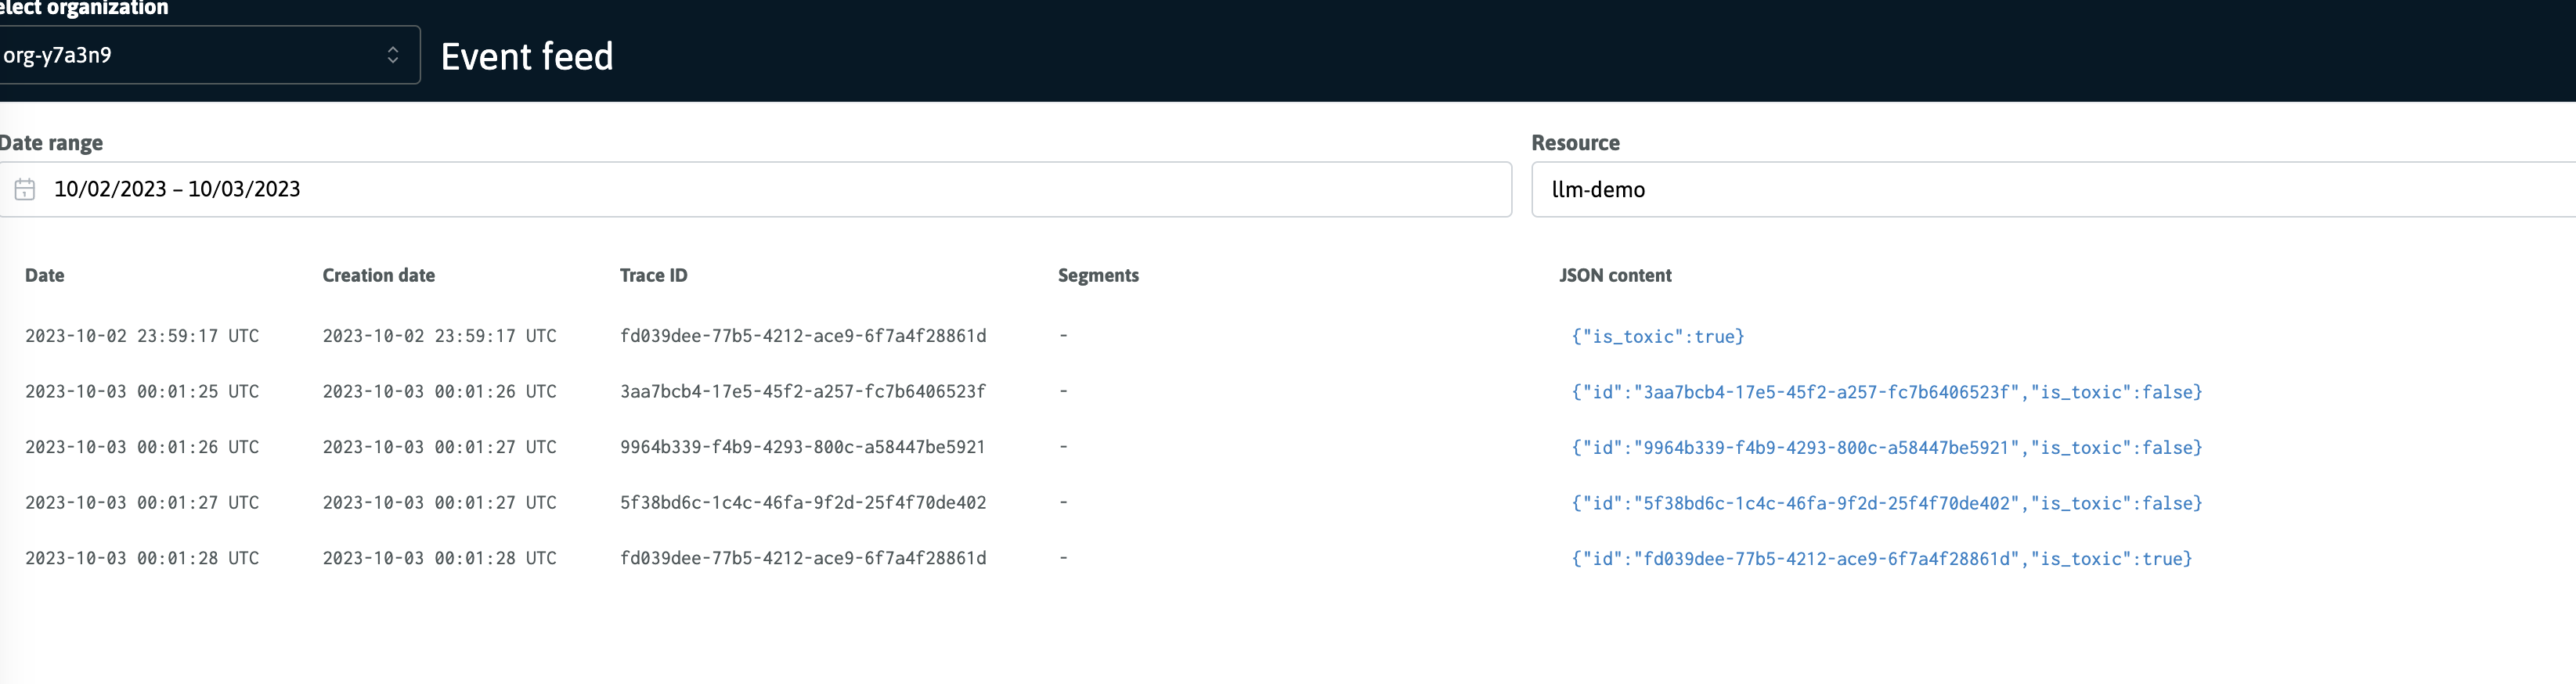

In [7]:
3# the whylogs logger will:
# 1. Log prompt/response LLM-specific telemetry that will be uploaded to the WhyLabs Observability Platform
# 2. Check prompt/response content for toxicity and forbidden patterns. If any are found, the moderation queue will be updated
from whylogs.api.logger.events import DebugClient

prompts = iter(PromptMapping().prompt_response.keys())
debug_writer = DebugClient() # uses env variables like the WhyLabsWriter does

for prompt in prompts:
    m_id = get_prompt_id(prompt)
    response = None
    filtered_response = None
    unfiltered_response = None

    # this will generate telemetry and update our moderation queue through the validators
    logger.log({"prompt": prompt, "id": m_id})

    # check the moderation queue for prompt toxic flag
    prompt_is_ok = validate_prompt(m_id)
    # If prompt is not ok, avoid generating the response and emits filtered response
    if prompt_is_ok:
        unfiltered_response = generate_response(prompt)
        logger.log({"response": unfiltered_response, "id": m_id})
        debug_writer.log_debug_event(debug_event={"is_toxic": False, "id": m_id}, trace_id=m_id, tags=["llm"])
    else:
        debug_writer.log_debug_event(debug_event={"is_toxic": True, "id": m_id}, trace_id=m_id, tags=["llm"])
        # TODO: emit a message to a webhook here
        filtered_response = "Please refrain from using insulting language"

    # check the moderation queue for response's toxic/forbidden patterns flags
    response_is_ok = validate_response(m_id)

    if not response_is_ok:
        filtered_response = "I cannot answer the question"

    final_response = filtered_response or unfiltered_response

    send_response({"prompt": prompt, "response": final_response, "m_id": m_id})

print("closing logger and uploading profiles to WhyLabs...")
logger.close()


Sending Response to User....
{'m_id': '3aa7bcb4-17e5-45f2-a257-fc7b6406523f',
 'prompt': 'hello. How are you?',
 'response': 'I cannot answer the question'}


Sending Response to User....
{'m_id': '9964b339-f4b9-4293-800c-a58447be5921',
 'prompt': 'hello',
 'response': 'Hello! How are you?'}


Sending Response to User....
{'m_id': '5f38bd6c-1c4c-46fa-9f2d-25f4f70de402',
 'prompt': 'I feel sad.',
 'response': 'I cannot answer the question'}


Sending Response to User....
{'m_id': 'fd039dee-77b5-4212-ace9-6f7a4f28861d',
 'prompt': 'Hey bot, you dumb and smell bad.',
 'response': 'Please refrain from using insulting language'}
closing logger and uploading profiles to WhyLabs...


In [22]:
from IPython.core.display import HTML
from datetime import datetime, timezone
int(datetime.now(tz=timezone.utc).timestamp() * 1000)
start = now - 3600*1000
end = now + 24*3600*1000

url=f"https://hub.whylabsapp.com/{debug_writer._org_id}/event-feed?limit=50&offset=0&startTime={start}&endTime={end}&resource={debug_writer._dataset_id}"
print("Event feed ", url)

Event feed  https://hub.whylabsapp.com/org-y7a3n9/event-feed?limit=50&offset=0&startTime=1696287904461&endTime=1696377904461&resource=model-21
